# Component antenna array

This example shows how to use PyAEDT to create an example using a 3D component file. It sets
up the analysis, solves it, and uses postprocessing functions to create plots using Matplotlib and
PyVista without opening the HFSS user interface. This example runs only on Windows using CPython.

Keywords: **HFSS**, **antenna array**, **3D components**, **far field**.

## Perform imports and define constants

Perform required imports.

In [1]:
import os
import tempfile
import time

In [2]:
import ansys.aedt.core
from ansys.aedt.core.visualization.advanced.farfield_visualization import \
    FfdSolutionData

Define constants

In [3]:
AEDT_VERSION = "2024.2"
NUM_CORES = 4
NG_MODE = False  # Open AEDT UI when it is launched.

## Create temporary directory

Create a temporary directory where downloaded data or
dumped data can be stored.
If you'd like to retrieve the project data for subsequent use,
the temporary folder name is given by ``temp_folder.name``.

In [4]:
temp_folder = tempfile.TemporaryDirectory(suffix=".ansys")

## Download 3D component
Download the 3D component that is needed to run the example.

In [5]:
example_path = ansys.aedt.core.downloads.download_3dcomponent(
    destination=temp_folder.name
)

## Launch HFSS and open project

Launch HFSS and open the project.

In [6]:
project_name = os.path.join(temp_folder.name, "array.aedt")
hfss = ansys.aedt.core.Hfss(
    project=project_name,
    version=AEDT_VERSION,
    design="Array_Simple",
    non_graphical=NG_MODE,
    new_desktop=True,
)

print("Project name " + project_name)

PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyAEDT INFO: PyAEDT version 0.12.dev0.


PyAEDT INFO: Initializing new Desktop session.


PyAEDT INFO: Log on console is enabled.


PyAEDT INFO: Log on file C:\Users\ansys\AppData\Local\Temp\pyaedt_ansys_373f7eff-eb91-4976-9e88-af49c6036d2a.log is enabled.


PyAEDT INFO: Log on AEDT is enabled.


PyAEDT INFO: Debug logger is disabled. PyAEDT methods will not be logged.


PyAEDT INFO: Launching PyAEDT with gRPC plugin.


PyAEDT INFO: New AEDT session is starting on gRPC port 55849


PyAEDT INFO: AEDT installation Path C:\Program Files\AnsysEM\v242\Win64


PyAEDT INFO: Ansoft.ElectronicsDesktop.2024.2 version started with process ID 7716.


PyAEDT INFO: Project array has been created.


PyAEDT INFO: Added design 'Array_Simple' of type HFSS.


PyAEDT INFO: Aedt Objects correctly read


Project name C:\Users\ansys\AppData\Local\Temp\tmp515dqq0j.ansys\array.aedt


## Read array definition

Read array definition from the JSON file.

In [7]:
dict_in = ansys.aedt.core.general_methods.read_json(
    os.path.join(example_path, "array_simple.json")
)

## Define 3D component

Define the 3D component cell.

In [8]:
dict_in["Circ_Patch_5GHz1"] = os.path.join(example_path, "Circ_Patch_5GHz.a3dcomp")

## Add 3D component array

A 3D component array is created from the previous dictionary.
If a 3D component is not available in the design, it is loaded
into the dictionary from the path that you specify. The following
code edits the dictionary to point to the location of the A3DCOMP file.

In [9]:
array = hfss.add_3d_component_array_from_json(dict_in)

PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Parsing C:/Users/ansys/AppData/Local/Temp/tmp515dqq0j.ansys/array.aedt.


PyAEDT INFO: File C:/Users/ansys/AppData/Local/Temp/tmp515dqq0j.ansys/array.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.0


PyAEDT INFO: Project array Saved correctly


PyAEDT INFO: Parsing C:/Users/ansys/AppData/Local/Temp/tmp515dqq0j.ansys/array.aedt.


PyAEDT INFO: File C:/Users/ansys/AppData/Local/Temp/tmp515dqq0j.ansys/array.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.07940459251403809


## Modify cells

Make the center element passive and rotate the corner elements.

In [10]:
array.cells[1][1].is_active = False
array.cells[0][0].rotation = 90
array.cells[0][2].rotation = 90
array.cells[2][0].rotation = 90
array.cells[2][2].rotation = 90

## Set up simulation and analyze

Set up a simulation and analyze it.

In [11]:
setup = hfss.create_setup()
setup.props["Frequency"] = "5GHz"
setup.props["MaximumPasses"] = 3
hfss.analyze(cores=NUM_CORES)

PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/HFSS correctly changed.


PyAEDT INFO: Solving all design setups.


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/HFSS correctly changed.


PyAEDT INFO: Design setup None solved correctly in 0.0h 0.0m 39.0s


True

## Get far field data

Get far field data. After the simulation completes, the far
field data is generated port by port and stored in a data class.

In [12]:
ffdata = hfss.get_antenna_data(setup=hfss.nominal_adaptive, sphere="Infinite Sphere1")

PyAEDT INFO: Far field sphere Infinite Sphere1 is created.


PyAEDT INFO: PostProcessor class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Post class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Solution Data Correctly Loaded.


PyAEDT INFO: Exporting antenna metadata...


PyAEDT INFO: Antenna metadata exported.


PyAEDT INFO: Exporting geometry...


PyAEDT INFO: Exporting embedded element patterns.... Done: 2.2003703117370605 seconds


## Generate contour plot

Generate a contour plot. You can define the Theta scan and Phi scan.

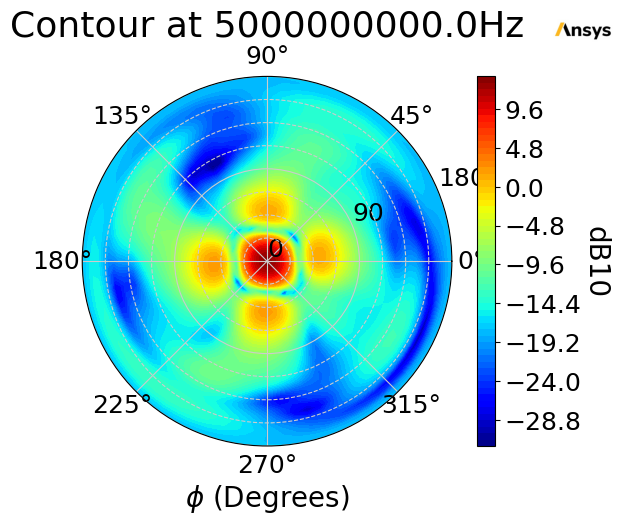

In [13]:
ffdata.farfield_data.plot_contour(
    quantity="RealizedGain",
    title="Contour at {}Hz".format(ffdata.farfield_data.frequency),
)

## Release AEDT

Release AEDT.
You can perform far field postprocessing without AEDT because the data is stored.

In [14]:
metadata_file = ffdata.metadata_file
working_directory = hfss.working_directory

In [15]:
hfss.save_project()
hfss.release_desktop()
# Wait 3 seconds to allow AEDT to shut down before cleaning the temporary directory.
time.sleep(3)

PyAEDT INFO: Project array Saved correctly


PyAEDT INFO: Desktop has been released and closed.


## Load far field data

Load the stored far field data.

In [16]:
ffdata = FfdSolutionData(input_file=metadata_file)

## Generate contour plot

Generate a contour plot. You can define the Theta scan
and Phi scan.

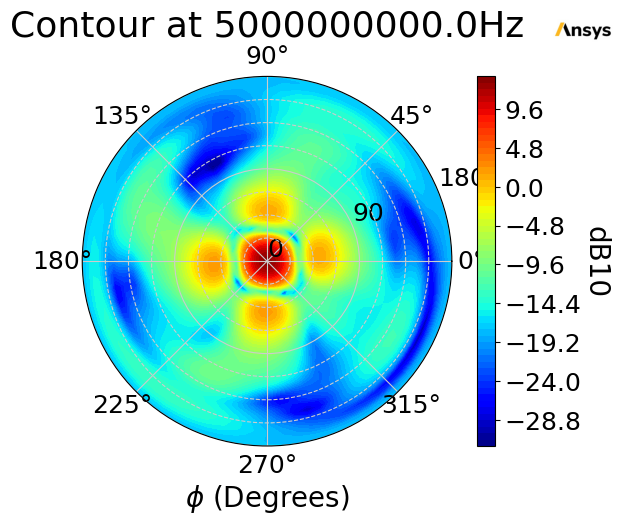

In [17]:
ffdata.plot_contour(
    quantity="RealizedGain", title="Contour at {}Hz".format(ffdata.frequency)
)

## Generate 2D cutout plots

Generate 2D cutout plots. You can define the Theta scan
and Phi scan.

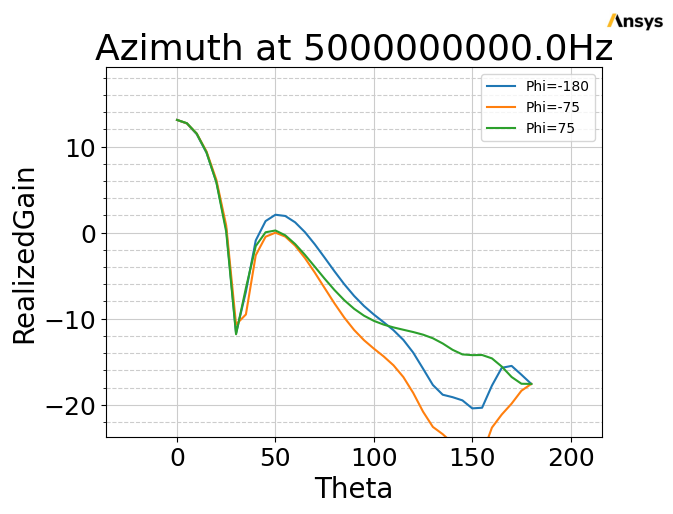

In [18]:
ffdata.plot_cut(
    quantity="RealizedGain",
    primary_sweep="theta",
    secondary_sweep_value=[-180, -75, 75],
    title="Azimuth at {}Hz".format(ffdata.frequency),
    quantity_format="dB10",
)

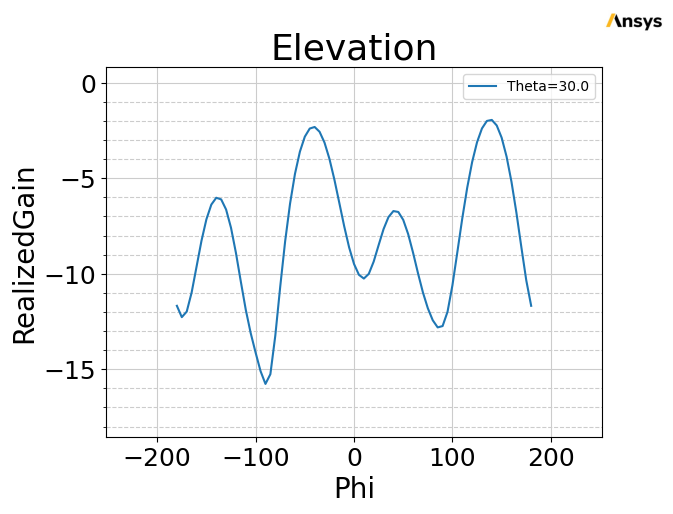

In [19]:
ffdata.plot_cut(
    quantity="RealizedGain",
    primary_sweep="phi",
    secondary_sweep_value=30,
    title="Elevation",
    quantity_format="dB10",
)

## Generate 3D plot

Generate 3D plots. You can define the Theta scan and Phi scan.

C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


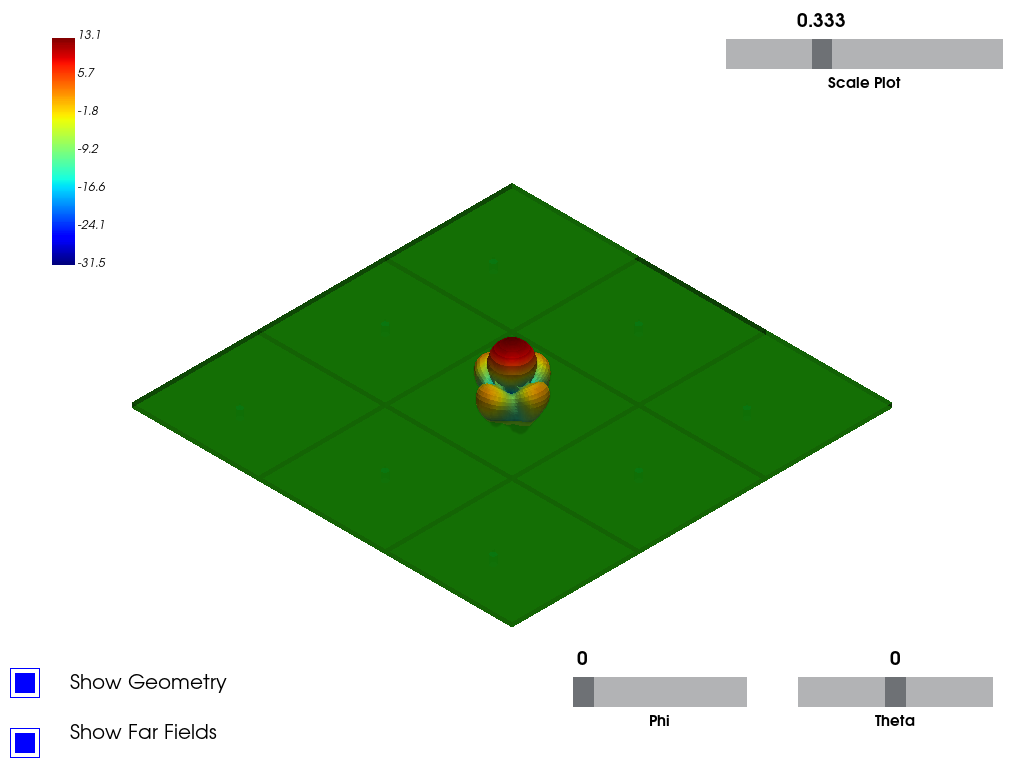

In [20]:
ffdata.plot_3d(
    quantity="RealizedGain",
    output_file=os.path.join(working_directory, "Image.jpg"),
    show=False,
)

## Clean up

All project files are saved in the folder ``temp_folder.name``.
If you've run this example as a Jupyter notebook, you
can retrieve those project files. The following cell
removes all temporary files, including the project folder.

In [21]:
temp_folder.cleanup()